In [1]:
import os
import glob
import cv2
import imageio

import numpy as np 
import pandas as pd 
import nibabel as nib
import matplotlib.pyplot as plt
from tabulate import tabulate
import pickle 

from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from matplotlib.pyplot import figure

from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

import pixellib
from pixellib.instance import instance_segmentation

In [2]:
# Create a meta file for nii files processing

file_list = []
for dirname, _, filenames in os.walk('./LITS17'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)   

,dirname,filename
0,./LITS17,segmentation-0.nii
1,./LITS17,segmentation-1.nii
2,./LITS17,segmentation-10.nii
3,./LITS17,segmentation-100.nii
4,./LITS17,segmentation-101.nii
...,...,...
257,./LITS17,volume-95.nii
258,./LITS17,volume-96.nii
259,./LITS17,volume-97.nii
260,./LITS17,volume-98.nii


In [3]:
# Map CT scan and label 

df_files["mask_dirname"]  = ""
df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "./LITS17"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 

df_files

,dirname,filename,mask_dirname,mask_filename
0,./LITS17,volume-0.nii,./LITS17,segmentation-0.nii
1,./LITS17,volume-1.nii,./LITS17,segmentation-1.nii
2,./LITS17,volume-10.nii,./LITS17,segmentation-10.nii
3,./LITS17,volume-100.nii,./LITS17,segmentation-100.nii
4,./LITS17,volume-101.nii,./LITS17,segmentation-101.nii
...,...,...,...,...
126,./LITS17,volume-95.nii,./LITS17,segmentation-95.nii
127,./LITS17,volume-96.nii,./LITS17,segmentation-96.nii
128,./LITS17,volume-97.nii,./LITS17,segmentation-97.nii
129,./LITS17,volume-98.nii,./LITS17,segmentation-98.nii


In [4]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [5]:
# Read sample

sample = 0
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])

print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')

CT Shape:   (512, 512, 75)
Mask Shape: (512, 512, 75)


In [6]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-3024.0 1410.0
0.0 2.0


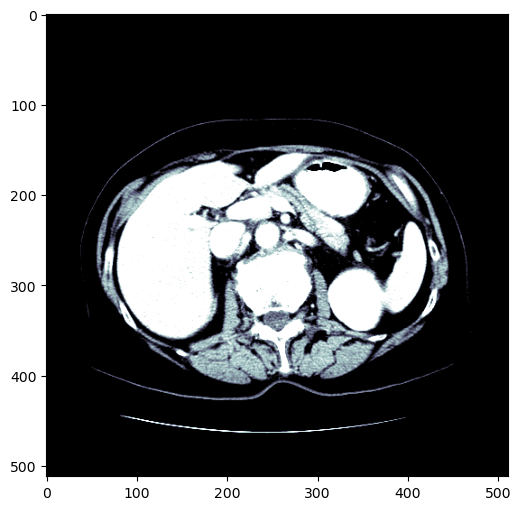

In [7]:
dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

figure(figsize=(8, 6), dpi=100)

plt.imshow(tensor(sample_ct[..., 55].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [8]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(20,16), dpi=100)

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Preprocessed Image')
    plt.axis('off')
             
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Segmentation image')
    plt.axis('off')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')
    plt.axis('off')
    
    plt.show()

# Image Pre-Processing

Histogram equalization:

In [9]:
imf = sample_ct[..., sample]
imf.shape

(512, 512)

In [10]:
#equ = cv2.equalizeHist(imf)

# Segmentation Using Enhanced Mask-RCNN

In [11]:
import os
os.chdir("./Mask_RCNN/samples")
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

In [12]:
segment_image = instance_segmentation()
dbfile = open('saved_model', 'rb')     
db = pickle.load(dbfile)
segment_image.load_model("train_model.h5")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

# Patch Embedding

In [ ]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)


def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches


class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])


class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out


class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()
        
        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        
        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        
        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
        
        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        
        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)
        
        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
            
        # Getting the classification token only
        out = out[:, 0]
        
        return self.mlp(out) # Map to output dimension, output category distribution
    


def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

# Adversarial propagation (AdvProp)

In [ ]:
def activate(weights, inputs):
    activation = weights[-1]
    for i in range(len(weights)-1):
        activation += weights[i] * inputs[i]
    return activation

def transfer(activation):
    return 1.0 / (1.0 + math.exp(-activation))

# adversarial propagation input to a network output
def AdvProp(network, row):
    inputs = row
    for layer in network:
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron['output'] = transfer(activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs
    return inputs

In [1]:
def main():
    # Loading data
    transform = ToTensor()

    train_set = LITS17(root='./train_images', train=True, download=True, transform=transform)
    test_set = LITS17(root='./train_images', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
    model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
    N_EPOCHS = 5
    LR = 0.005

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")

network = [[{'weights': [0.13436424411240122, 0.8474337369372327, 0.763774618976614]}],
		[{'weights': [0.2550690257394217, 0.49543508709194095]}, {'weights': [0.4494910647887381, 0.651592972722763]}]]
row = [1, 0, None]
output = AdvProp(network, row)

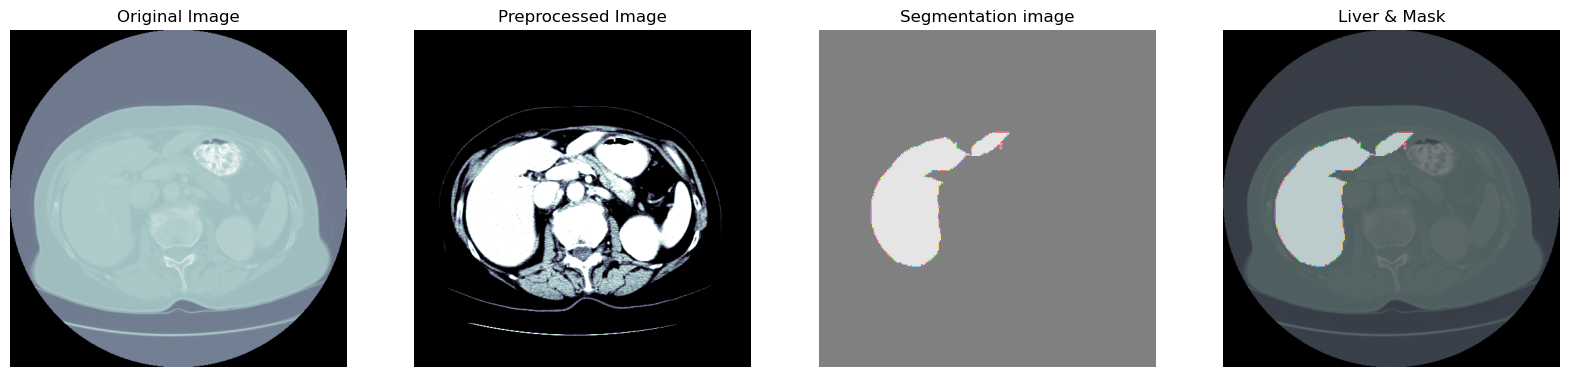

In [14]:
sample = 55

sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[..., sample],
             sample_mask[..., sample]])

# Evaluation Metrics

### Dice Coefficient:

In [15]:
import numpy as np

k=1

# segmentation
seg = np.zeros((100,100), dtype='int')
seg[30:70, 30:70] = k

# ground truth
gt = np.zeros((100,100), dtype='int')
gt[30:70, 40:80] = k

dice = np.sum(seg[gt==k])*2.0 / (np.sum(seg) + np.sum(gt))

print('Dice similarity score is {}'.format(dice))

Dice similarity score is 0.75


In [16]:
voe = 100 * (1. - np.logical_and(seg, gt).sum() / np.logical_or(seg, gt))

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_2508\2830058102.py:1: RuntimeWarning: divide by zero encountered in divide
  voe = 100 * (1. - np.logical_and(seg, gt).sum() / np.logical_or(seg, gt))


In [17]:
# create header
head = ['Case Nu,','VOE','ASD (mm)','MSD (mm)','RVD','Dice']
 
# display table
print(tabulate(db['met'], headers=head, tablefmt="grid"))

+------------+-------+------------+------------+---------+--------+
| Case Nu,   |   VOE |   ASD (mm) |   MSD (mm) |     RVD |   Dice |
+============+=======+============+============+=========+========+
| 1          | 0.103 |      1.568 |     28.453 | -0.029  |  0.955 |
+------------+-------+------------+------------+---------+--------+
| 2          | 0.089 |      1.471 |     34.951 | -0.033  |  0.963 |
+------------+-------+------------+------------+---------+--------+
| 3          | 0.1   |      1.382 |     31.259 | -0.049  |  0.956 |
+------------+-------+------------+------------+---------+--------+
| 4          | 0.097 |      1.494 |     25.494 | -0.048  |  0.968 |
+------------+-------+------------+------------+---------+--------+
| 5          | 0.114 |      1.797 |     28.315 | -0.04   |  0.949 |
+------------+-------+------------+------------+---------+--------+
| 6          | 0.107 |      1.933 |     29.756 | -0.038  |  0.953 |
+------------+-------+------------+------------+

In [18]:
# create header
head = ['Model,','Accuracy','Precision','Recall','F1']
 
# display table
print(tabulate(db['perm'], headers=head, tablefmt="grid"))

+-------------------+------------+-------------+----------+-------+
| Model,            |   Accuracy |   Precision |   Recall |    F1 |
+===================+============+=============+==========+=======+
| CNN-RNN [31]      |      80.1  |       87.21 |    80.15 | 80.43 |
+-------------------+------------+-------------+----------+-------+
| Ga-CNN [32]       |      85.71 |       84.32 |    85.93 | 83.45 |
+-------------------+------------+-------------+----------+-------+
| GAN-R-CNN [33]    |      92.1  |       92.43 |    92.15 | 91.68 |
+-------------------+------------+-------------+----------+-------+
| SAR-U-Net [34]    |      92.46 |       93.48 |    92.44 | 91.81 |
+-------------------+------------+-------------+----------+-------+
| HCNN [35]         |      89.52 |       90.21 |    89.54 | 89.03 |
+-------------------+------------+-------------+----------+-------+
| RF [36]           |      94.53 |       96.61 |    92.52 | 92.24 |
+-------------------+------------+-------------+

In [19]:
# create header
head = ['Model,','Accuracy','Precision','Recall','F1']
 
# display table
print(tabulate(db['perm1'], headers=head, tablefmt="grid"))

+-------------------+------------+-------------+----------+--------+
| Model,            |   Accuracy |   Precision |   Recall |     F1 |
+===================+============+=============+==========+========+
| CNN-RNN [31]      |      81.1  |       99.41 |    75.91 | 86.723 |
+-------------------+------------+-------------+----------+--------+
| Ga-CNN [32]       |      87.7  |       99.41 |    85.21 | 91.82  |
+-------------------+------------+-------------+----------+--------+
| GAN-R-CNN [33]    |      92.5  |       99.82 |    90.98 | 95.27  |
+-------------------+------------+-------------+----------+--------+
| SAR-U-Net [34]    |      92.9  |       99.78 |    91.52 | 95.41  |
+-------------------+------------+-------------+----------+--------+
| HCNN [35]         |      92.5  |       99.63 |    91.38 | 95.18  |
+-------------------+------------+-------------+----------+--------+
| RF [36]           |      92.7  |       99.9  |    91.93 | 95.32  |
+-------------------+------------+

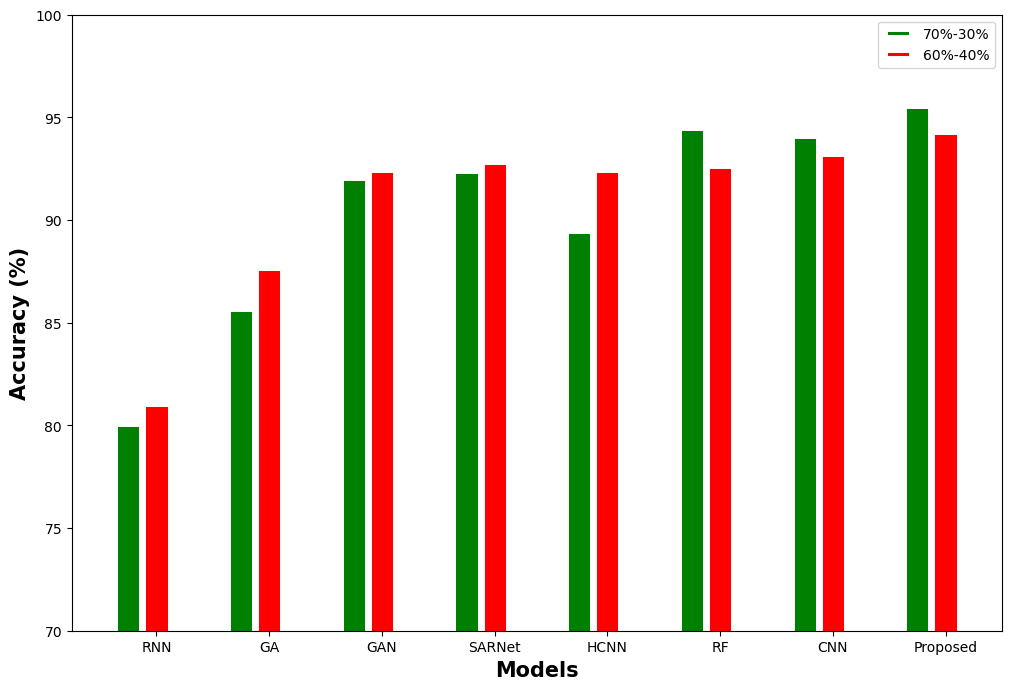

In [20]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# Set position of bar on X axis
br1 = np.arange(len(db['acc']))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, db['acc'], color ='g', width = barWidth,label ='70%-30%',edgecolor='white', linewidth=5)
plt.bar(br2, db['ac'], color ='r', width = barWidth, label ='60%-40%',edgecolor='white', linewidth=5)

 
# Adding Xticks
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy (%)', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(db['acc']))],
        ['RNN', 'GA', 'GAN', 'SARNet', 'HCNN','RF','CNN','Proposed'])
 
plt.legend()

plt.ylim(70, 100)
plt.show()

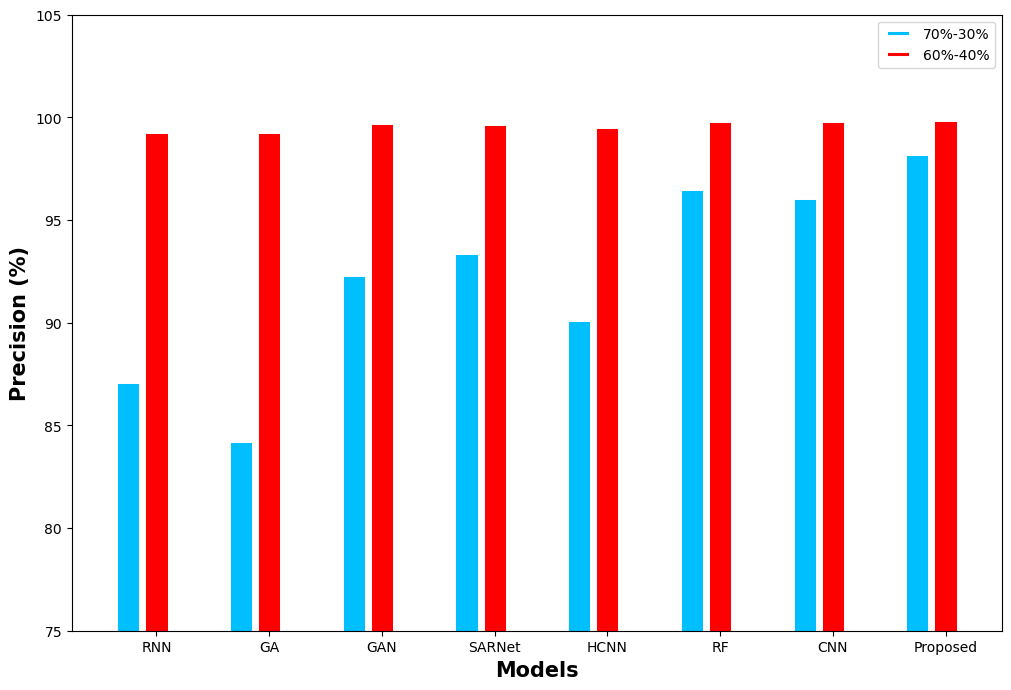

In [21]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# Set position of bar on X axis
br1 = np.arange(len(db['pre']))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, db['pre'], color ='deepskyblue', width = barWidth,label ='70%-30%',edgecolor='white', linewidth=5)
plt.bar(br2, db['pr'], color ='r', width = barWidth, label ='60%-40%',edgecolor='white', linewidth=5)

 
# Adding Xticks
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('Precision (%)', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(db['pre']))],
        ['RNN', 'GA', 'GAN', 'SARNet', 'HCNN','RF','CNN','Proposed'])
 
plt.legend()

plt.ylim(75, 105)
plt.show()

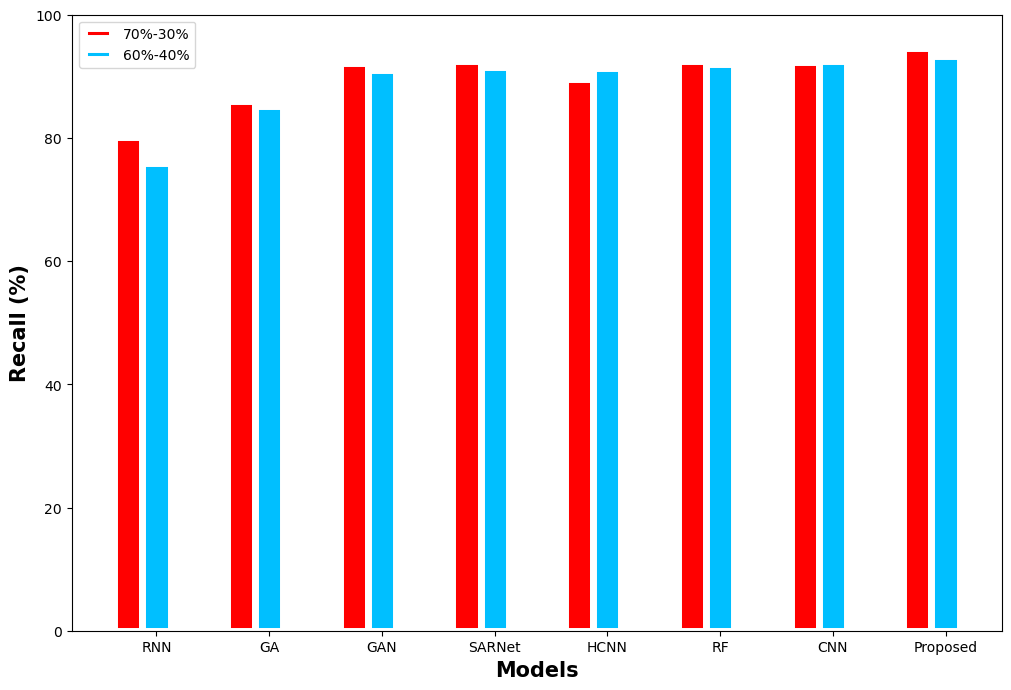

In [22]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 

# Set position of bar on X axis
br1 = np.arange(len(db['rec']))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, db['rec'], color ='r', width = barWidth,label ='70%-30%',edgecolor='white', linewidth=5)
plt.bar(br2, db['re'], color ='deepskyblue', width = barWidth, label ='60%-40%',edgecolor='white', linewidth=5)

 
# Adding Xticks
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('Recall (%)', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(db['rec']))],
        ['RNN', 'GA', 'GAN', 'SARNet', 'HCNN','RF','CNN','Proposed'])
 
plt.legend()

plt.ylim(0, 100)
plt.show()

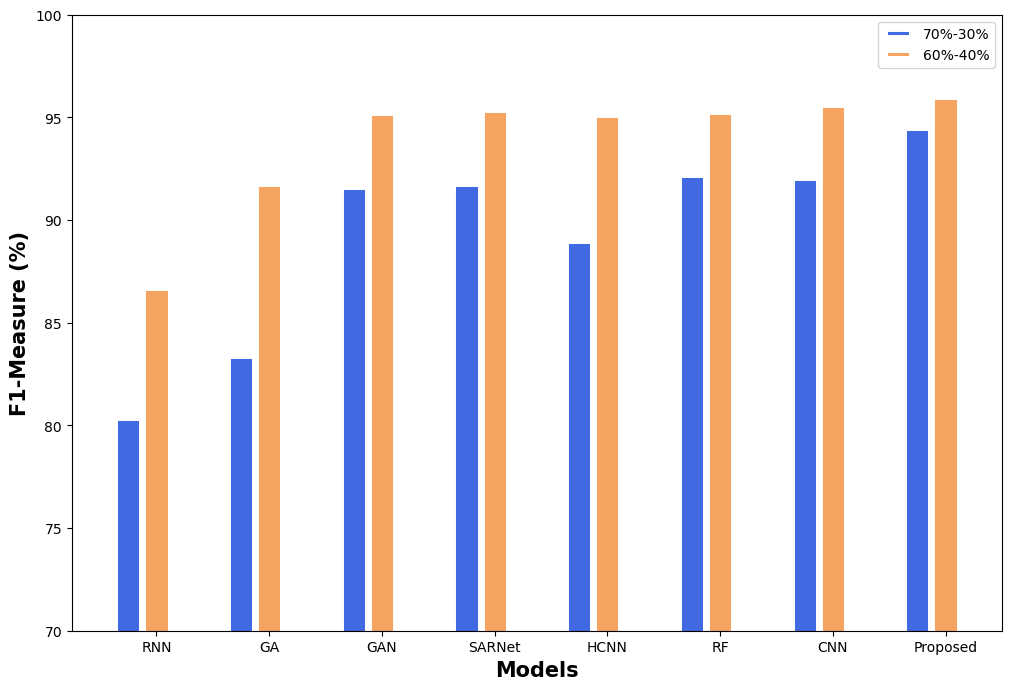

In [23]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
fme = [80.43,83.45,91.68,91.81,89.03,92.24,92.10,94.53]
fm = [86.72,91.82,95.27,95.41,95.18,95.32,95.63,96.02]
 
# Set position of bar on X axis
br1 = np.arange(len(db['fme']))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, db['fme'], color ='royalblue', width = barWidth,label ='70%-30%',edgecolor='white', linewidth=5)
plt.bar(br2, db['fm'], color ='sandybrown', width = barWidth, label ='60%-40%',edgecolor='white', linewidth=5)

 
# Adding Xticks
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('F1-Measure (%)', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(db['fme']))],
        ['RNN', 'GA', 'GAN', 'SARNet', 'HCNN','RF','CNN','Proposed'])
 
plt.legend()

plt.ylim(70, 100)
plt.show()